# Определение перспективного тарифа для компании Мегалайн

## Описание проекта

«Мегалайн» — федеральный оператор сотовой связи.
Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Проведем предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Проанализируем поведение клиентов и сделаем вывод - какой тариф лучше.

## Описание тарифов

### Тариф «Смарт»

Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

### Тариф «Ультра»

Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

_Обратить внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута._


## Описание данных

**Таблица users (информация о пользователях):**

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

**Таблица calls (информация о звонках):**

- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**

- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**

- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**

- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


## Общая информация из имеющихся данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
calls = pd.read_csv('calls.csv') # информация о звонках
internet = pd.read_csv('internet.csv') # информация об интернет-сессиях
messages = pd.read_csv('messages.csv') # информация о сообщениях
tariffs = pd.read_csv('tariffs.csv') # информация о тарифах
users = pd.read_csv('users.csv') # информация о пользователях

### Изучим датасет Calls 

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
calls.duplicated().sum()

0

Вывод: 
 - Необходимо изменить типы данных в столбцах call_date : id, call_date, user_id
 - Пустых значений и дубликатов не имеется

### Изучим датасет Internet

In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [7]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [8]:
internet.duplicated().sum()

0

Вывод: 
 - Необходимо удалить столбец unnamed, так как он дублирует индексацию таблицы
 - Также нужно изменить типы данных в столбцах : id , session_date
 - Пустых значений и дубликатов не имеется

### Изучим датасет Messages

In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [10]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [11]:
messages.duplicated().sum()

0

Вывод:

 - Изменить типы данных в столбце : id, message_date
 - Пустых значений и дубликатов не имеется

### Изучим датасет Tariffs

In [12]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [13]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [14]:
tariffs.duplicated().sum()

0

Вывод:

 - Типы данных указаны верно. Изменять ничего не нужно
 - Пустых значений и дубликатов не имеется

### Изучим датасет Users

In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [16]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Посмотрим на имеющиеся данные о возрасте.

In [17]:
users['age'].value_counts()

53    14
42    14
63    13
64    13
71    13
73    12
21    12
40    12
37    11
29    11
39    11
26    11
47    11
70    10
45    10
41    10
52    10
58    10
36    10
66     9
23     9
50     9
65     9
19     9
48     9
24     9
68     9
27     9
28     9
51     9
20     9
56     9
30     9
60     8
44     8
69     8
62     8
55     8
74     7
25     7
46     7
35     7
32     7
67     7
43     7
31     7
18     6
75     6
54     6
59     6
72     5
22     5
34     5
33     5
38     5
49     4
57     4
61     3
Name: age, dtype: int64

Посмотрим сколько пользователей какого тарифа мы имеем.

In [18]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Посмотрим на столбец `first_name`.

In [19]:
users['first_name'].value_counts()

Радим      6
Леонид     5
Пётр       5
Андрей     4
Адам       4
          ..
Зинаида    1
Глеб       1
Роза       1
Юзефа      1
Трифон     1
Name: first_name, Length: 246, dtype: int64

Посмотрим на столбец `last_name`.

In [20]:
users['last_name'].value_counts()

Андреенко     5
Березина      3
Аркадьев      3
Булгаков      3
Соловьев      3
             ..
Медведев      1
Минаева       1
Авдонюшкин    1
Андрейчук     1
Акимчин       1
Name: last_name, Length: 419, dtype: int64

Посмотрим на столбец `city`.

In [21]:
users['city'].value_counts()

Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Архангельск         1
Иваново             1
Нижневартовск       1
Химки               1
Подольск            1
Name: city, Length: 76, dtype: int64

In [22]:
users.duplicated().sum()

0

Вывод:

  - Изменить типы данных в : churn_date, reg_date, 
  - Привести к нижнему регистру названия городов, Имена и фамилии
  - Имеются пустые значения в столбце churn_date, необходимо будет поработать с данным столбцом и решить, что будет делать с данным столбцом: игнорировать или проводить замены пустых значений на другие. 
  - Дубликатов нет.

### Вывод по изучению общей информации

## Предобработка данных

 - Приведем данные к нужным типам;
 - Попробуем найти и исправить ошибки в данных.
 

Также: 

 - Посчитаем для каждого пользователя:
   - количество сделанных звонков и израсходованных минут разговора по месяцам;
   - количество отправленных сообщений по месяцам;
   - объем израсходованного интернет-трафика по месяцам;
   - помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

### Изменим типы данных

In [23]:
calls['id'] = calls['id'].astype('int64')
calls['call_date'] = pd.to_datetime(calls['call_date'])

In [24]:
calls.dtypes

id                    int64
call_date    datetime64[ns]
duration            float64
user_id               int64
dtype: object

In [25]:
internet['id'] = internet['id'].astype(int)
internet['session_date'] = pd.to_datetime(internet['session_date'])

Удалим столбец `unnamed` в таблице Internet.

In [26]:
internet.drop('Unnamed: 0', axis='columns', inplace=True)
internet.dtypes

id                       int32
mb_used                float64
session_date    datetime64[ns]
user_id                  int64
dtype: object

In [27]:
internet.head()

,id,mb_used,session_date,user_id
0,10000,112.95,2018-11-25,1000
1,10001,1052.81,2018-09-07,1000
2,10002,1197.26,2018-06-25,1000
3,10003,550.27,2018-08-22,1000
4,10004,302.56,2018-09-24,1000


In [28]:
messages['id'] = messages['id'].astype(int)
messages['message_date'] = pd.to_datetime(messages['message_date'])

In [29]:
messages.dtypes

id                       int32
message_date    datetime64[ns]
user_id                  int64
dtype: object

In [30]:
messages.head()

,id,message_date,user_id
0,10000,2018-06-27,1000
1,10001,2018-10-08,1000
2,10002,2018-08-04,1000
3,10003,2018-06-16,1000
4,10004,2018-12-05,1000


In [31]:
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['city'] = users['city'].str.lower()
users['first_name'] = users['first_name'].str.lower()
users['last_name'] = users['last_name'].str.lower()

In [32]:
users.sample(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
461,1461,53,NaT,москва,ангелина,фетисова,2018-11-21,ultra
386,1386,21,NaT,новосибирск,фаддей,родионов,2018-08-13,smart
357,1357,37,NaT,томск,касьян,ермилов,2018-09-02,smart
362,1362,47,NaT,владимир,нина,колесова,2018-08-02,smart
366,1366,43,NaT,санкт-петербург,василиса,фетисова,2018-06-14,smart
389,1389,29,NaT,москва,надежда,латышева,2018-07-20,smart
24,1024,73,NaT,санкт-петербург,иулиан,антипов,2018-10-31,ultra
94,1094,37,NaT,новосибирск,даниэла,пугачева,2018-05-28,ultra
97,1097,29,NaT,краснодар,алла,кулешова,2018-06-25,ultra
61,1061,41,NaT,санкт-петербург,тамара,ситникова,2018-07-15,smart


### Округлим значения minutes и mb_used у тарифа Ultra


In [33]:
calls['duration'] = calls['duration'].apply(np.ceil)
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

### Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам

Добавим столбец month в таблицу calls, для того, чтобы можно было вывести количество звонков и израсходованных минут по месяцам.

In [34]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls_times = calls.pivot_table(index=['month', 'user_id'], values='duration', aggfunc=['count', 'sum']).rename(columns={'duration': 'total_calls'})
calls_times

count         sum
              total_calls total_calls
month user_id                        
1     1005             15        95.0
      1032             61       380.0
      1045              1         9.0
      1055             64       551.0
      1071             24       194.0
...                   ...         ...
12    1494             62       418.0
      1495            155      1031.0
      1496             80       518.0
      1497             71       545.0
      1499             69       492.0

[3174 rows x 2 columns]

### Посчитаем количество отправленных сообщений по месяцам

In [35]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages_times = messages.pivot_table(index=['month','user_id'], values='id', aggfunc='count')
messages_times

id
month user_id    
1     1005      7
      1032     38
      1045      5
      1055     30
      1071     16
...            ..
12    1493     78
      1495     84
      1496     51
      1497     17
      1499     66

[2717 rows x 1 columns]

### Посчитаем объем израсходованного интернет-трафика по месяцам

In [36]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet_times = internet.pivot_table(index=['month','user_id'], values='mb_used', aggfunc='sum')
internet_times.head(100)

mb_used
month user_id         
1     1005      2730.0
      1032     24147.0
      1045      2348.0
      1055     17111.0
      1071     15622.0
...                ...
2     1373     20194.0
      1375     11753.0
      1378     10818.0
      1381     27761.0
      1385     32655.0

[100 rows x 1 columns]

### Посчитаем помесячную выручку с каждого пользователя 

In [37]:
tempdata = pd.DataFrame(calls_times.to_records())
tempdata

,month,user_id,"('count', 'total_calls')","('sum', 'total_calls')"
0,1,1005,15,95.0
1,1,1032,61,380.0
2,1,1045,1,9.0
3,1,1055,64,551.0
4,1,1071,24,194.0
...,...,...,...,...
3169,12,1494,62,418.0
3170,12,1495,155,1031.0
3171,12,1496,80,518.0
3172,12,1497,71,545.0


Создадим датафрейм `monthly_profit` для подсчета прибыли компании и перенесем в него столбцы из временного датафрейма с количеством звонков и общим количеством проговоренных минут. Так же переименуем столбцы.

In [38]:
monthly_profit = pd.DataFrame()
monthly_profit['user_id'] = tempdata['user_id']
monthly_profit['month']   = tempdata['month']
monthly_profit['calls']   = tempdata.iloc[:, 2]
monthly_profit['minutes'] = tempdata.iloc[:, 3]
monthly_profit

,user_id,month,calls,minutes
0,1005,1,15,95.0
1,1032,1,61,380.0
2,1045,1,1,9.0
3,1055,1,64,551.0
4,1071,1,24,194.0
...,...,...,...,...
3169,1494,12,62,418.0
3170,1495,12,155,1031.0
3171,1496,12,80,518.0
3172,1497,12,71,545.0


Создадим новый временный датафрейм с таблицей messages и переименуем столбец `id` в `messages`.

In [39]:
tempdata = pd.DataFrame(messages_times.to_records()).rename(columns={'id': 'messages'})
tempdata

,month,user_id,messages
0,1,1005,7
1,1,1032,38
2,1,1045,5
3,1,1055,30
4,1,1071,16
...,...,...,...
2712,12,1493,78
2713,12,1495,84
2714,12,1496,51
2715,12,1497,17


Соединим временный датафрейм с нашим monthly_profit таблицей.

In [40]:
monthly_profit = monthly_profit.merge(tempdata, on=['user_id', 'month'], how='outer')
monthly_profit

,user_id,month,calls,minutes,messages
0,1005,1,15.0,95.0,7.0
1,1032,1,61.0,380.0,38.0
2,1045,1,1.0,9.0,5.0
3,1055,1,64.0,551.0,30.0
4,1071,1,24.0,194.0,16.0
...,...,...,...,...,...
3208,1106,12,NaN,NaN,24.0
3209,1231,12,NaN,NaN,191.0
3210,1328,12,NaN,NaN,7.0
3211,1473,12,NaN,NaN,20.0


Создадим новый временный датафрейм с таблицей internet и соединим его с нашим monthly_profit таблицей.

In [41]:
tempdata = pd.DataFrame(internet_times.to_records())
monthly_profit = monthly_profit.merge(tempdata, on=['user_id', 'month'], how='outer')
monthly_profit

,user_id,month,calls,minutes,messages,mb_used
0,1005,1,15.0,95.0,7.0,2730.0
1,1032,1,61.0,380.0,38.0,24147.0
2,1045,1,1.0,9.0,5.0,2348.0
3,1055,1,64.0,551.0,30.0,17111.0
4,1071,1,24.0,194.0,16.0,15622.0
...,...,...,...,...,...,...
3209,1231,12,NaN,NaN,191.0,32481.0
3210,1328,12,NaN,NaN,7.0,39461.0
3211,1473,12,NaN,NaN,20.0,18432.0
3212,1489,12,NaN,NaN,35.0,17341.0


Создадим датафрейм tariff_times и перенесем в него столбцы из таблицы users, чтобы соединить их с monthly_profit таблицей.

In [42]:
tariff_times = pd.DataFrame()
tariff_times[['user_id','tariff','city','age']] = users[['user_id','tariff','city','age']]
monthly_profit = monthly_profit.merge(tariff_times, on='user_id', how='outer')
monthly_profit

,user_id,month,calls,minutes,messages,mb_used,tariff,city,age
0,1005,1.0,15.0,95.0,7.0,2730.0,smart,набережные челны,67
1,1005,2.0,69.0,456.0,38.0,7394.0,smart,набережные челны,67
2,1005,3.0,77.0,606.0,56.0,11117.0,smart,набережные челны,67
3,1005,4.0,101.0,712.0,41.0,9365.0,smart,набережные челны,67
4,1005,5.0,73.0,595.0,42.0,7877.0,smart,набережные челны,67
...,...,...,...,...,...,...,...,...,...
3211,1328,10.0,NaN,NaN,6.0,22447.0,ultra,мурманск,44
3212,1328,11.0,NaN,NaN,8.0,35567.0,ultra,мурманск,44
3213,1328,12.0,NaN,NaN,7.0,39461.0,ultra,мурманск,44
3214,1128,NaN,NaN,NaN,NaN,NaN,ultra,волжский,51


In [43]:
monthly_profit.isnull().sum()

user_id       0
month         2
calls        42
minutes      42
messages    499
mb_used      13
tariff        0
city          0
age           0
dtype: int64

Заменим пустые значения нулем.

In [44]:
monthly_profit = monthly_profit.fillna(0)

Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану.

In [45]:
smart_megabytes_included = 15360
smart_messages_included = 50
smart_minutes_included = 500
smart_monthly_price = 550
smart_price_for_megabyte = 0.1953
smart_price_for_message = 3
smart_price_for_minute = 3

ultra_megabytes_included = 30720
ultra_messages_included = 1000
ultra_minutes_included = 3000
ultra_monthly_price = 1950
ultra_price_for_megabyte = 0.1464
ultra_price_for_message = 1
ultra_price_for_minute = 1

Напишем функцию для подсчета прибыли.

In [46]:
def profit_of_megaline(row):
    # Объявим переменные из столбцов нашей таблицы
    mb_used = row['mb_used']
    tariff = row['tariff']
    minutes = row['minutes']
    messages = row['messages']
    total_megabytes = 0
    total_messages = 0 
    total_minutes = 0
    
    # Проведем расчеты, если тариф Смарт, то будут использоваться эти расчеты
    if tariff == 'smart':
        if mb_used > smart_megabytes_included:
            total_megabytes = (mb_used - smart_megabytes_included) * smart_price_for_megabyte
        if minutes > smart_minutes_included:
            total_minutes = (minutes - smart_minutes_included) * smart_price_for_minute
        if messages > smart_messages_included:
            total_messages = (messages - smart_messages_included) * smart_price_for_message
        
        return total_megabytes + total_minutes + total_messages + smart_monthly_price
    
    # Если тариф Ультра, то возьмем эти расчеты
    elif tariff == 'ultra':
        if mb_used > ultra_megabytes_included:
            total_megabytes = (mb_used - ultra_megabytes_included) * ultra_price_for_megabyte
        if minutes > ultra_minutes_included:
            total_minutes = (minutes - ultra_minutes_included) * ultra_price_for_minute
        if messages > ultra_messages_included:
            total_messages = (messages - ultra_messages_included) * ultra_price_for_message
        return total_megabytes + total_minutes + total_messages + ultra_monthly_price

In [47]:
monthly_profit['profit'] = monthly_profit.apply(profit_of_megaline, axis=1)

In [48]:
monthly_profit.sample(20)

,user_id,month,calls,minutes,messages,mb_used,tariff,city,age,profit
3133,1463,12.0,93.0,715.0,31.0,25978.0,ultra,санкт-петербург,74,1950.0000
2764,1456,8.0,23.0,152.0,0.0,6792.0,smart,санкт-петербург,40,550.0000
179,1204,4.0,42.0,268.0,0.0,18688.0,smart,москва,18,1199.9584
2020,1002,7.0,26.0,214.0,11.0,17601.0,smart,стерлитамак,59,987.6673
1373,1119,7.0,34.0,277.0,44.0,20127.0,smart,петрозаводск,53,1480.9951
3029,1405,11.0,42.0,340.0,67.0,12786.0,ultra,набережные челны,54,1950.0000
2855,1283,11.0,40.0,264.0,19.0,18863.0,smart,москва,50,1234.1359
1473,1200,8.0,92.0,627.0,49.0,16318.0,ultra,санкт-петербург,36,1950.0000
648,1217,10.0,69.0,463.0,74.0,14747.0,smart,ульяновск,42,622.0000
2432,1280,10.0,91.0,619.0,44.0,20210.0,smart,астрахань,53,1854.2050


### Вывод по предобработке данных

* Привели к правильным типам данных наши таблицы;
* Удалили лишние столбцы с таблиц;
* Заменили пустые значения на 0 в пустых столбцах.

Также: 

 - Посчитали для каждого пользователя:
   - количество сделанных звонков и израсходованных минут разговора по месяцам;
   - количество отправленных сообщений по месяцам;
   - объем израсходованного интернет-трафика по месяцам;
   - помесячную выручку с каждого пользователя

## Анализ данных

### Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?


Передадим переменным `smart_tariff` и `ultra_tariff` соответствующие данные из таблицы.

In [49]:
smart_tariff = monthly_profit[monthly_profit['tariff']=='smart']
ultra_tariff = monthly_profit[monthly_profit['tariff']=='ultra']

Посчитаем сколько минут разговора, сколько сообщений и какой объем интернет-трафика требуется пользователям тарифа Smart в месяц.

In [50]:
smart_pivot = smart_tariff.pivot_table(index='month', values=['minutes','messages','mb_used','profit'], aggfunc='sum')
smart_stat = pd.DataFrame(smart_pivot.to_records())
smart_stat

,month,mb_used,messages,minutes,profit
0,0.0,0.0,0.0,0.0,550.0000
1,1.0,289831.0,620.0,6931.0,23886.5965
2,2.0,673461.0,1397.0,17324.0,46650.8275
3,3.0,1164537.0,2453.0,30034.0,86113.2362
4,4.0,1509702.0,3443.0,41119.0,103300.1209
5,5.0,2231353.0,4762.0,54618.0,161711.4951
6,6.0,2593622.0,5478.0,64885.0,188525.8817
7,7.0,3168466.0,6784.0,82079.0,234774.3990
8,8.0,3908561.0,7905.0,99045.0,295738.4932
9,9.0,4244377.0,8746.0,111439.0,311750.4821


Посчитаем сколько минут разговора, сколько сообщений и какой объем интернет-трафика требуется пользователям тарифа Ultra в месяц.

In [51]:
ultra_pivot = ultra_tariff.pivot_table(index='month', values=['minutes','messages','mb_used','profit'], aggfunc='sum')
ultra_stat = pd.DataFrame(ultra_pivot.to_records())
ultra_stat.drop(0)

,month,mb_used,messages,minutes,profit
1,1.0,118382.0,304.0,3853.0,17550.0000
2,2.0,282887.0,527.0,7131.0,47352.8064
3,3.0,649423.0,1195.0,18117.0,74153.1912
4,4.0,926409.0,1736.0,25191.0,109747.2912
5,5.0,1298540.0,2536.0,34192.0,137678.6640
6,6.0,1591148.0,3505.0,40295.0,170689.1448
7,7.0,1866833.0,4536.0,49667.0,191865.4224
8,8.0,2096565.0,5183.0,54653.0,221605.8144
9,9.0,2210554.0,6013.0,62036.0,231574.2456
10,10.0,2467856.0,7187.0,68644.0,252993.3528


### Посчитаем среднее количество, дисперсию и стандартное отклонение.

Посчитаем среднее, медиану, дисперсию и среднее отклонение для тарифа Smart.

In [52]:
for column in smart_tariff[['minutes','messages','mb_used','profit']]:
    print('Среднее {}: {:.0f}'.format(column,smart_tariff[column].mean()))
    print('Медиана {}: {:.0f}'.format(column,smart_tariff[column].median()))
    print('Дисперсия {}: {:.0f}'.format(column,np.var(smart_tariff[column])))
    print('Среднее отклонение {}: {:.0f} \n'.format(column, np.std(smart_tariff[column])))

Среднее minutes: 418
Медиана minutes: 422
Дисперсия minutes: 36265
Среднее отклонение minutes: 190 

Среднее messages: 33
Медиана messages: 28
Дисперсия messages: 797
Среднее отклонение messages: 28 

Среднее mb_used: 16222
Медиана mb_used: 16529
Дисперсия mb_used: 34632986
Среднее отклонение mb_used: 5885 

Среднее profit: 1233
Медиана profit: 960
Дисперсия profit: 620038
Среднее отклонение profit: 787 



Посчитаем среднее, медиану, дисперсию и среднее отклонение для тарифа Ultra.

In [53]:
for column in ultra_tariff[['minutes','messages','mb_used','profit']]:
    print('Среднее {}: {:.0f}'.format(column,ultra_tariff[column].mean()))
    print('Медиана {}: {:.0f}'.format(column,ultra_tariff[column].median()))
    print('Дисперсия {}: {:.0f}'.format(column,np.var(ultra_tariff[column])))
    print('Среднее отклонение {}: {:.0f} \n'.format(column, np.std(ultra_tariff[column])))

Среднее minutes: 526
Медиана minutes: 518
Дисперсия minutes: 100950
Среднее отклонение minutes: 318 

Среднее messages: 49
Медиана messages: 38
Дисперсия messages: 2283
Среднее отклонение messages: 48 

Среднее mb_used: 19467
Медиана mb_used: 19320
Дисперсия mb_used: 102113596
Среднее отклонение mb_used: 10105 

Среднее profit: 2060
Медиана profit: 1950
Дисперсия profit: 126562
Среднее отклонение profit: 356 



### Построим гистограммы и опишем распределения

In [54]:
def histogram_drawing(column, title):
    sns.set_style('darkgrid')
    plt.figure(figsize=(12, 6))
    plt.title(title, fontsize=15)
    sns.histplot(smart_tariff[column], label='Тариф Smart', kde=False)
    sns.histplot(ultra_tariff[column], label='Тариф Ultra', kde=False)
    plt.axvline(np.mean(smart_tariff[column]), color='g', linestyle='--', label='Smart среднее')
    plt.axvline(np.mean(ultra_tariff[column]), color='g', linestyle='-', label='Ultra среднее')
    plt.legend()

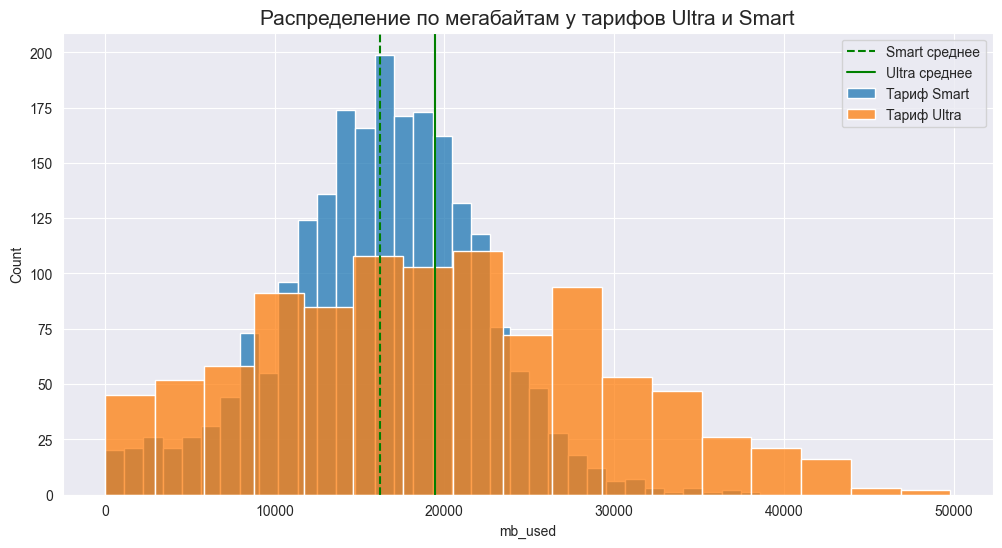

In [55]:
histogram_drawing('mb_used', 'Распределение по мегабайтам у тарифов Ultra и Smart')

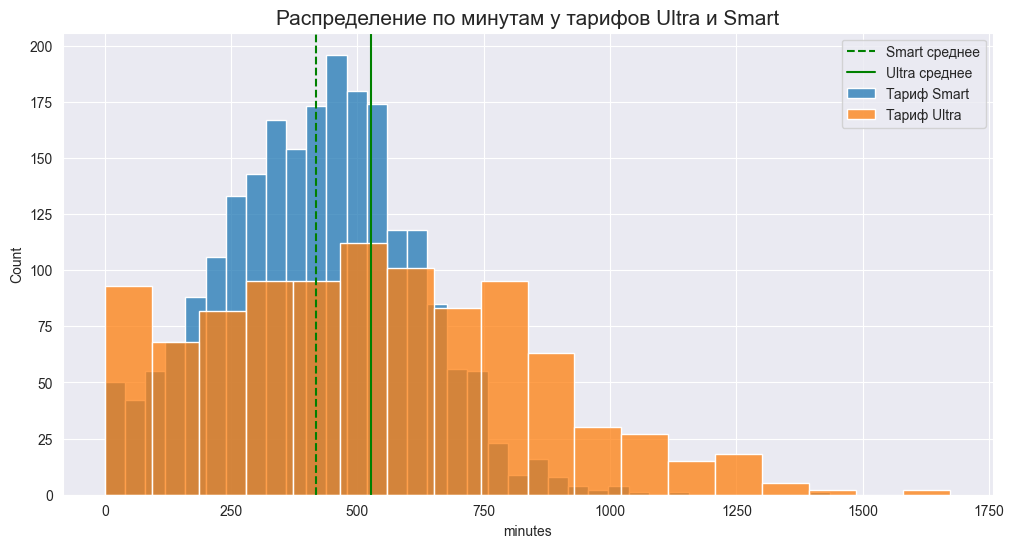

In [56]:
histogram_drawing('minutes','Распределение по минутам у тарифов Ultra и Smart')

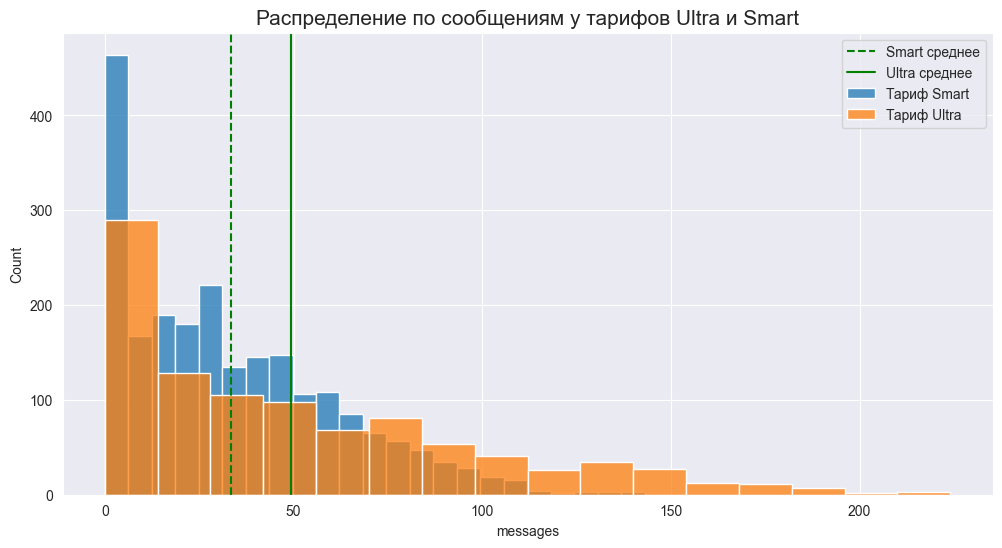

In [57]:
histogram_drawing('messages','Распределение по сообщениям у тарифов Ultra и Smart')

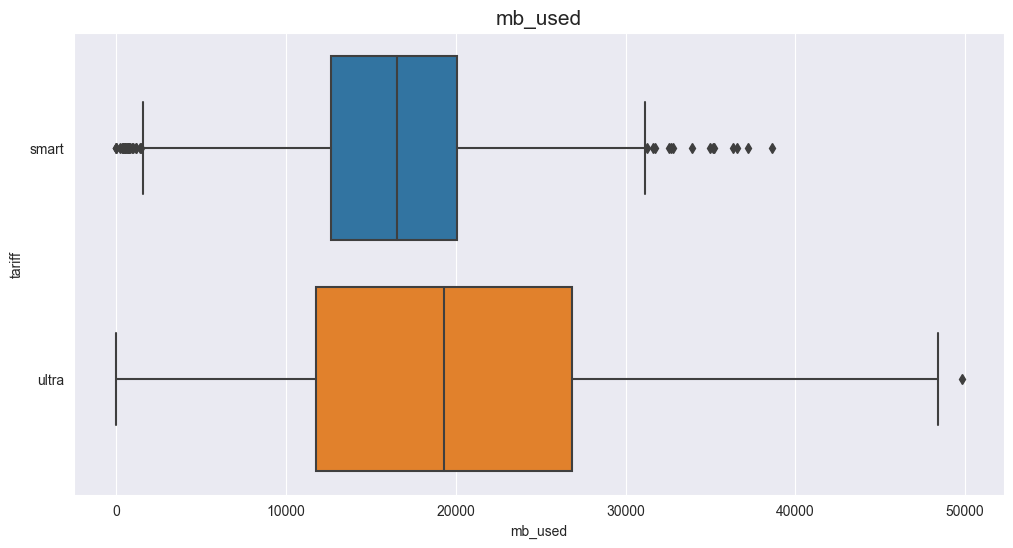

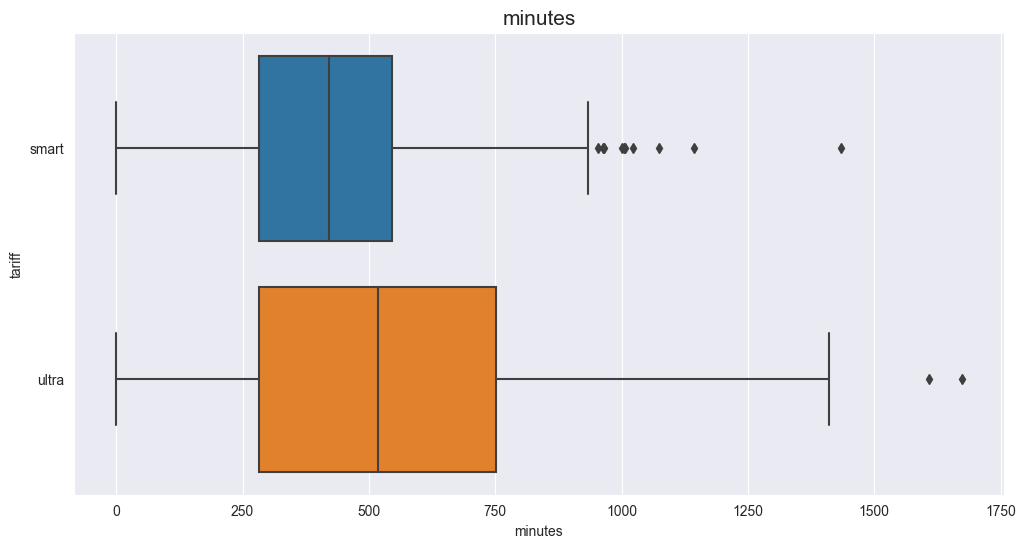

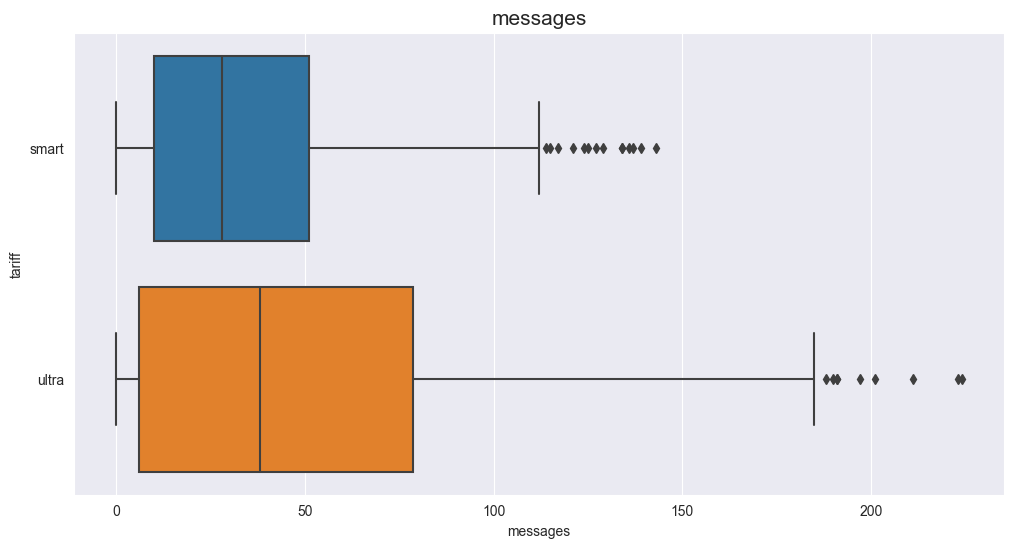

In [58]:
for columns in monthly_profit[['mb_used','minutes','messages']]:
    plt.figure(figsize=(12,6))
    plt.title(columns, fontsize=15)
    sns.boxplot(data=monthly_profit, x=columns, y='tariff')

**Вывод**:
Исходя из полученных графиков видно, что пользователи тарифа **Smart** в среднем:
 - проговаривают 400 минут, когда пользователи тарифа **Ultra** проговаривают 500 минут
 - скачивают ~ 16000 мегабайт, когда пользователи тарифа **Ultra** скачивают ~ 20 000 мегабайт
 - отправляют 33 сообщений, когда пользователи тарифа **Ultra** отправляют ~ 49 сообщений

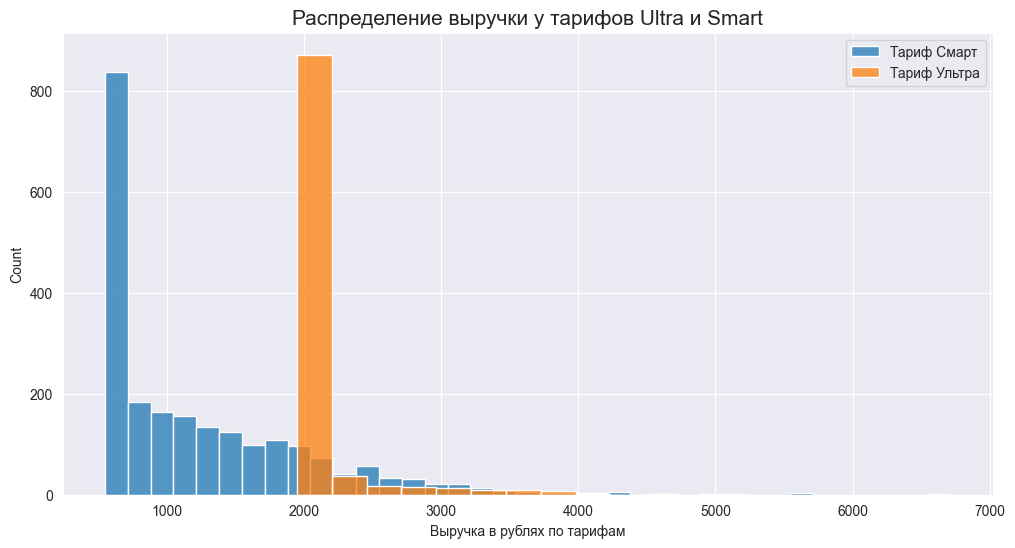

In [59]:
plt.figure(figsize=(12, 6))
plt.title('Распределение выручки у тарифов Ultra и Smart', fontsize=15)
ax = sns.histplot(data=smart_tariff, x='profit', label='Тариф Смарт', kde=False)
ax = sns.histplot(data=ultra_tariff, x='profit', label='Тариф Ультра', kde=False)
ax.set(xlabel='Выручка в рублях по тарифам')
plt.legend();

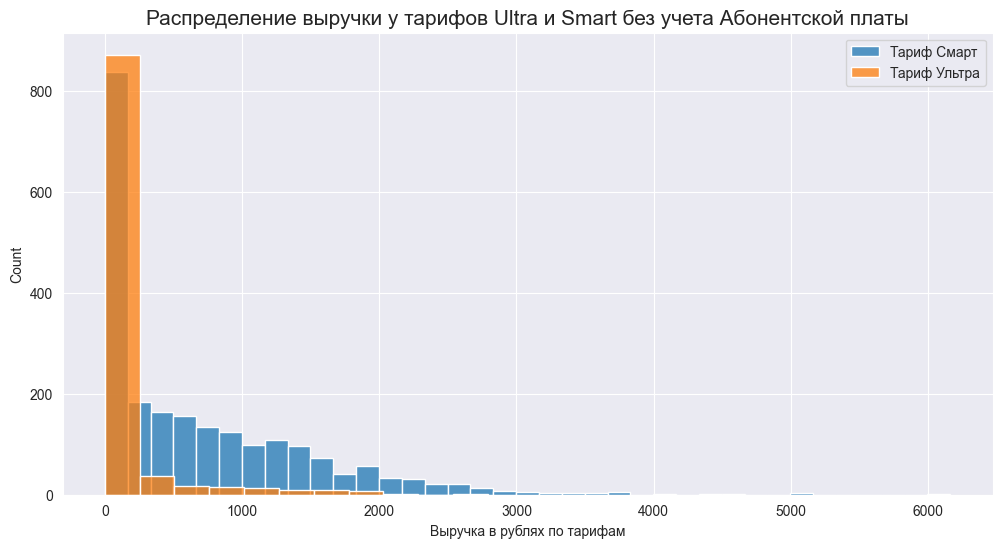

In [60]:
plt.figure(figsize=(12, 6))
plt.title('Распределение выручки у тарифов Ultra и Smart без учета Абонентской платы', fontsize=15)
ax = sns.histplot(data=smart_tariff['profit'] - 550, label='Тариф Смарт', kde=False)
ax = sns.histplot(data=ultra_tariff['profit'] - 1950, label='Тариф Ультра', kde=False)
ax.set(xlabel='Выручка в рублях по тарифам')
plt.legend();

Исходя из графика видно, что больше всего сверх абонентской платы оплачивают пользователи тарифа Смарт. Большинству пользователей тарифа Ультра достаточно пакета с имеющимися минутами и мегабайтами.

In [61]:
smart = users[users['tariff']=='smart']
ultra = users[users['tariff']=='ultra']

print('Количество клиентов с тарифом Ультра: {}'.format(ultra['tariff'].count()))
print('Количество клиентов с тарифом Смарт: {}\n'.format(smart['tariff'].count()))
print('В среднем один пользователь тарифа Ультра приносит: {:.0f} рублей'.format(ultra_tariff['profit'].sum()/ultra['tariff'].count()))
print('В среднем один пользователь тарифа Смарт приносит: {:.0f} рублей\n'.format(smart_tariff['profit'].sum()/smart['tariff'].count()))
print('Годавая прибыль по тарифу Ультра: {:.0f} рублей'.format(ultra_tariff['profit'].sum()))
print('Годовая прибыль по тарифу Смарт: {:.0f} рублей\n'.format(smart_tariff['profit'].sum()))

Количество клиентов с тарифом Ультра: 149
Количество клиентов с тарифом Смарт: 351

В среднем один пользователь тарифа Ультра приносит: 13634 рублей
В среднем один пользователь тарифа Смарт приносит: 7834 рублей

Годавая прибыль по тарифу Ультра: 2031509 рублей
Годовая прибыль по тарифу Смарт: 2749609 рублей



### Вывод по Анализу Данных

> Как и ожидалось, пользователи тарифа Ультра, тратят больше интернет-трафика, делают больше звонков и отправляют больше сообщений больше, чем пользователи тарифа Смарт.

> Если смотреть по средней выручке от каждого пользователя, то мы можем видеть, что каждый пользователь тарифа Ультра приносит компании в среднем 13 630 рублей в год. Когда пользователь тарифа Смарт приносит лишь 7834 рублей в год.

> Но если посчитать годовую выручку компании, то мы видим, что выручка по тарифу Смарт приносит компании 2 749 609 рублей в год, когда выручка по тарифу Ультра приносит 2 031 509 рублей в год.

> *Количество пользователей тарифа Смарт 351, а пользователей тарифа Ультра 149.*

## Проверим Гипотезы

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается


Сформулируем нулевые гипотезы:
    - Нулевая гипотеза H₀: Средняя выручка пользователей тарифов Смарт и Ультра не различается
    - Альтернативная гипотеза H₁: Средняя выручка пользователей тарифов Смарт и Ультра различается

In [62]:
# Посчитаем данные по выручке от каждого пользователя 
ultra_hyp = monthly_profit[monthly_profit['tariff']=='ultra']['profit']
smart_hyp = monthly_profit[monthly_profit['tariff']=='smart']['profit']

ultra_hyp

68      1950.0000
69      1950.0000
70      1950.0000
71      1950.0000
72      1950.0000
          ...    
3205    1950.0000
3211    1950.0000
3212    2659.6008
3213    3229.6824
3214    1950.0000
Name: profit, Length: 986, dtype: float64

In [63]:
smart_hyp.mean()

1233.0084148430494

Выполним проверку гипотезы. Будем использовать метод `ttest_ind`.

In [64]:
alpha = .05

results = st.ttest_ind(ultra_hyp, smart_hyp, equal_var=False)

print('p-значение:', results.pvalue)


if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.983459782936036e-296
Отвергаем нулевую гипотезу


_Исходя из нашего теста мы видим, что средняя выручка в тарифах ультра и смарт различается. Отвергаем нулевую гипотезу._

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Сформулируем нулевые гипотезы : 
    - Нулевая гипотеза H₀: Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
    - Альтернативная гипотеза H₁: Средняя выручка пользователей ииз Москвы отличается от выручки пользователей из других регионов

In [65]:
moscow_city = monthly_profit[monthly_profit['city']=='москва'].profit
others_city = monthly_profit[monthly_profit['city']!='москва'].profit
moscow_city.mean()

1507.2323355155481

In [66]:
others_city.mean()

1481.8422722840692

In [67]:
alpha = .05

results = st.ttest_ind(moscow_city, others_city, equal_var = False)

print('p-значение:', results.pvalue)


if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.45173745836083723
Не получилось отвергнуть нулевую гипотезу


_Исходя из нашего теста мы видим, что средняя выручка пользователей с Москвы не отличается от пользователей из других регионов. Проведя тест мы не смогли отвергнуть нулевую гипотезу._

## Общий вывод

- Мы изучили наши таблицы, проверили их на наличие пустых значений, дубликатов и неправильных типов данных. После, в предобработке мы поменяли типы данных практически во всех столбцах, так как многие были указаны неверно. И подготовили все таблицы для дальнейшего анализа.

- По ТЗ: посчитали: Сколько минут разговора, сколько сообщений и какой объем интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитали среднее количество, дисперсию и стандартное отклонение.

- Проверили гипотезы. Убедились, что выручка тарифов Смарт и Ультра различается. Убедились, что выручка клиентов с Москвы и других регионов не отличается.

- Изучив данные, мы выявили, что клиенты тарифа Ультра расходуют больше интернет-трафика, делают больше звонков и отправляют больше сообщений, нежели клиенты тарифа Смарт и практически не превышают лимит своего пакета, чего не скажешь о клиентах тарифа Смарт. Но по годовой выручке, компания получает больше выручки по тарифу Смарт, так как пользователей данного тарифа больше, чем Ультра. Если считать по каждому пользователю, то в среднем пользователь тарифа Ультра приносит больше выручки в год, чем пользователь Смарта.

- Если брать считать по итоговой прибыли от тарифов Ультра и Смарт, то Смарт выгоден для компании аж на 700к рублей в год. Но если считать ценность пользователя каждого тарифа, то пользователь тарифа Ультра приносит больше дохода, чем один пользователь тарифа Смарт.
